In [10]:
from astropy.io import fits
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import glob, h5py


plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

import os
if os.environ['USER'] == 'dhayaa':
    os.environ['PATH'] = f"{os.environ['PATH']}:/software/texlive-2021-el7-x86_64/bin/x86_64-linux"
    
    
COLORS = ["f07167","219ebc","c767ac", "59a270", "ffba0a"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
custom_cmap = LinearSegmentedColormap.from_list(None, [COLORS[1], 'white', COLORS[2]])
custom_cmap.set_bad(color = 'xkcd:light gray')


def discretize_cmap(cmap, num_colors): return ListedColormap([cmap(i / (num_colors - 1)) for i in range(num_colors)])

# First check DEEP SOM

In [2]:
deep_cell = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/collated_deep_classifier.npy')
deep_id   = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/DEEP_DATA_ID.npy')
df_cat    = pd.read_csv('/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts_20240723.csv.gz')
df_cat    = pd.merge(df_cat, pd.DataFrame({'ID' : deep_id, 'cell' : deep_cell.astype(int)}), 
                     on = 'ID', how = 'inner', validate = '1:1')

/tmp/ipykernel_9281/137013917.py:3: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cat    = pd.read_csv('/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts_20240723.csv.gz')


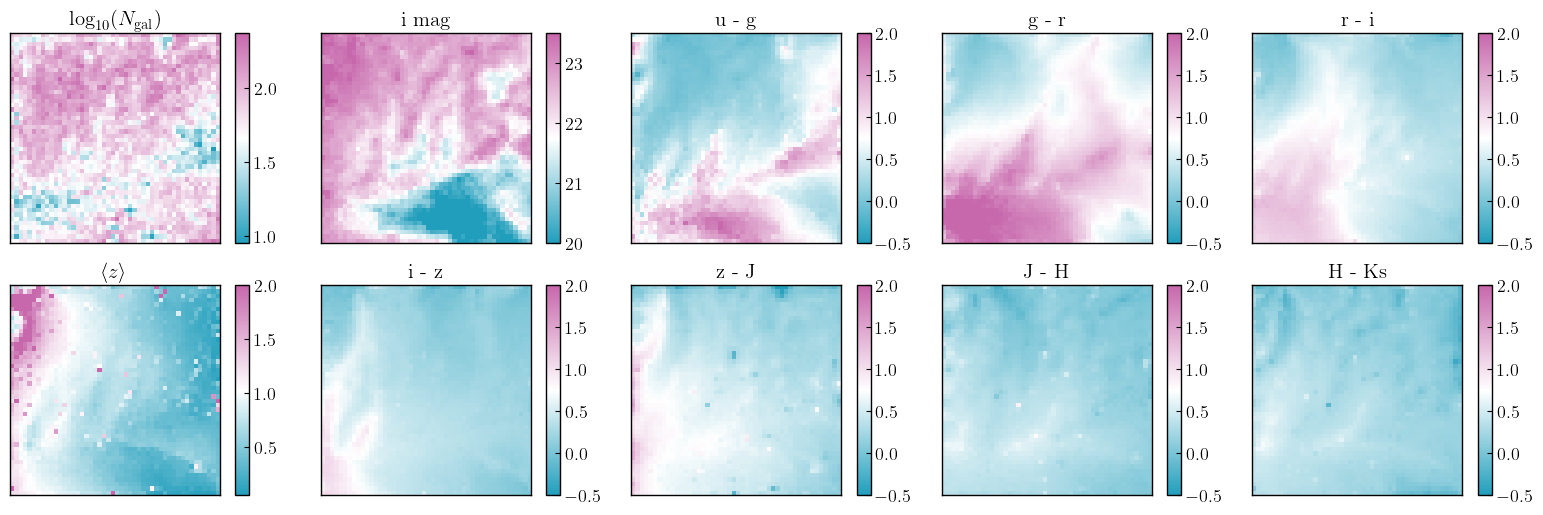

In [3]:
fig, ax = plt.subplots(2, 5, sharex = True, sharey = True, figsize = (20, 6))
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)
plt.xticks([])
plt.yticks([])

shrink = 1
aspect = 15

bins = (0,0)
SOM  = np.log10(1 + np.bincount(df_cat.cell.values))
m = ax[bins].imshow(SOM.reshape(48, 48), cmap = custom_cmap)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\log_{10}(N_{\rm gal})$', size = 15)


bins = (0,1)
a    = 30 - 2.5*np.log10(df_cat['BDF_FLUX_DERED_CALIB_I'][:])
SOM  = np.bincount(df_cat.cell.values, weights = a)/np.bincount(df_cat.cell.values)
m = ax[bins].imshow(SOM.reshape(48, 48), cmap = custom_cmap, vmin = 20, vmax = 23.5)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'i mag', size = 15)


bins = (1,0)
a    = df_cat['Z'][:]
m    = df_cat['Z'][:] > 0
SOM  = np.bincount(df_cat.cell.values[m], weights = a[m])/np.bincount(df_cat.cell.values[m])
SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
m = ax[bins].imshow(SOM.reshape(48, 48), cmap = custom_cmap, vmin = 0.05, vmax = 2)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\langle z \rangle$', size = 15)


bands = ['u', 'g', 'r', 'i', 'z', 'J', 'H', 'Ks']
axes  = [2, 3, 4, 6, 7, 8, 9]

for i, ax_i in enumerate(axes):
    b_1  = bands[i]
    b_2  = bands[i + 1]
    a    = -2.5*np.log10(df_cat[f'BDF_FLUX_DERED_CALIB_{b_1.upper()}'][:]/df_cat[f'BDF_FLUX_DERED_CALIB_{b_2.upper()}'][:])
    SOM  = np.bincount(df_cat.cell.values, weights = a)/np.bincount(df_cat.cell.values)
    SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
    m = ax.flat[ax_i].imshow(SOM.reshape(48, 48), cmap = custom_cmap, vmin = -0.5, vmax = 2)
    plt.colorbar(m, ax = ax.flat[ax_i], shrink = shrink, aspect = aspect)
    ax.flat[ax_i].set_title(f'{b_1} - {b_2}', size = 15)
    
plt.savefig('./DeepSOM.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

# Next check WIDE SOM

In [2]:
wide_cell = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/collated_wide_classifier.npy').astype(int)
wide_flux = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/WIDE_DATA_FLUX.npy')

brog_cell = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/collated_balrog_classifier.npy').astype(int)
brog_ID   = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/BALROG_DATA_ID.npy')
brog_ra   = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/BALROG_DATA_TRUE_RA.npy')
brog_dec  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/BALROG_DATA_TRUE_DEC.npy')

with h5py.File('/project/chihway/dhayaa/DECADE/BalrogOfTheDECADE_20240123.hdf5', 'r') as f:   
    mask  = np.isfinite(f['ra'][:])
    b_cat = pd.DataFrame({'ra' : f['ra'][:][mask], 'dec' : f['dec'][:][mask], 'ID' : f['ID'][:][mask]})

df_cat    = pd.read_csv('/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts_20240723.csv.gz')
b_cat     = pd.merge(b_cat, pd.DataFrame({'ra' : brog_ra, 'dec' : brog_dec, 'cell' : brog_cell.astype(int)}), 
                     on = ['ra', 'dec'], how = 'inner', validate = '1:1')
b_cat     = pd.merge(b_cat, df_cat[['ID', 'Z', 'SOURCE']], how = 'left', on = 'ID', validate = 'm:1')

/tmp/ipykernel_29599/3322079552.py:13: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cat    = pd.read_csv('/project/chihway/dhayaa/DECADE/Redshift_files/deepfields_raw_with_redshifts_20240723.csv.gz')


/tmp/ipykernel_29599/1544499274.py:39: RuntimeWarning: invalid value encountered in divide
  SOM  = np.bincount(b_cat.cell.values[m], weights = a[m])/np.bincount(b_cat.cell.values[m])
/tmp/ipykernel_29599/1544499274.py:52: RuntimeWarning: invalid value encountered in divide
  SOM  = np.bincount(b_cat.cell.values[m], weights = a[m], minlength = 32**2)/np.bincount(b_cat.cell.values[m], minlength = 32**2)
/tmp/ipykernel_29599/1544499274.py:61: RuntimeWarning: invalid value encountered in divide
  z_m  = np.bincount(b_cat.cell.values[m], weights = a[m]) / np.bincount(b_cat.cell.values[m])
/tmp/ipykernel_29599/1544499274.py:62: RuntimeWarning: invalid value encountered in divide
  SOM  = np.bincount(b_cat.cell.values[m], weights = (a[m] - z_m[b_cat.cell.values[m]])**2)/np.bincount(b_cat.cell.values[m])


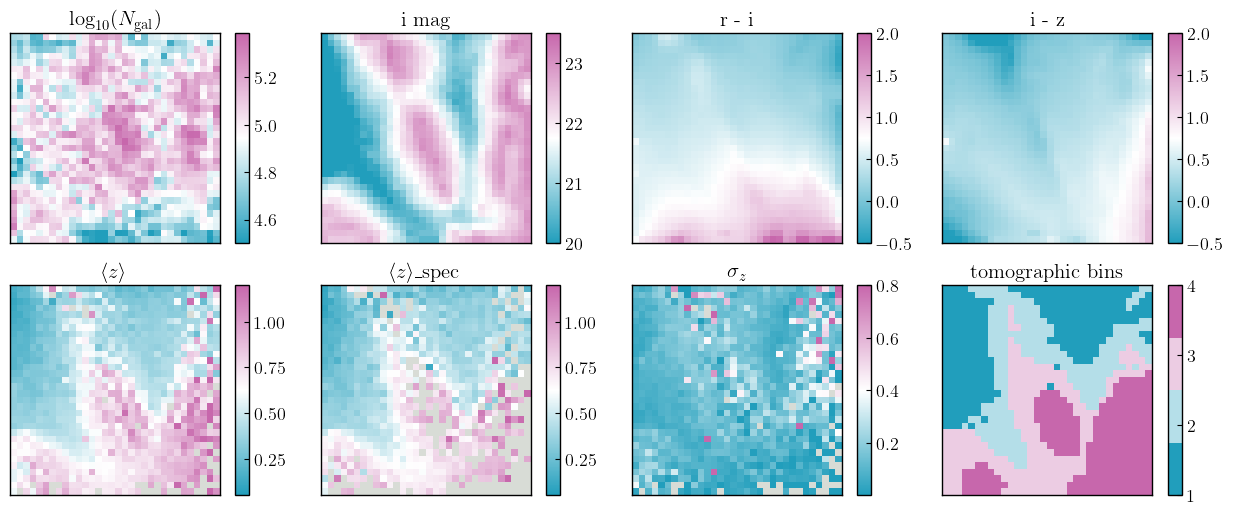

In [11]:
fig, ax = plt.subplots(2, 4, sharex = True, sharey = True, figsize = (16, 6))
plt.subplots_adjust(hspace = 0.2, wspace = 0.01)
plt.xticks([])
plt.yticks([])

shrink = 1
aspect = 15

bins = (0,0)
SOM  = np.log10(1 + np.bincount(wide_cell))
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = 4.5)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\log_{10}(N_{\rm gal})$', size = 15)


bins = (0,1)
a    = 30 - 2.5*np.log10(wide_flux[:, 1])
SOM  = np.bincount(wide_cell, weights = a)/np.bincount(wide_cell)
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = 20, vmax = 23.5)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'i mag', size = 15)


bands = ['r', 'i', 'z']
axes  = [2, 3]

for i, ax_i in enumerate(axes):
    a    = -2.5*np.log10(wide_flux[:, i]/wide_flux[:, i + 1])
    SOM  = np.bincount(wide_cell, weights = a)/np.bincount(wide_cell)
    SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
    m = ax.flat[ax_i].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = -0.5, vmax = 2)
    plt.colorbar(m, ax = ax.flat[ax_i], shrink = shrink, aspect = aspect)
    ax.flat[ax_i].set_title(f'{bands[i]} - {bands[i + 1]}', size = 15)
    
    
bins = (1,0)
a    = b_cat['Z'][:]
m    = (b_cat['Z'][:] > 0) & (b_cat['SOURCE'][:])
SOM  = np.bincount(b_cat.cell.values[m], weights = a[m])/np.bincount(b_cat.cell.values[m])
SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = 0.05, vmax = 1.2)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\langle z \rangle$', size = 15)

bins = (1,1)
a    = b_cat['Z'][:]
m    = (b_cat['Z'][:] > 0) & ((b_cat['SOURCE'][:] == 'C3R2') | 
                              (b_cat['SOURCE'][:] == 'ZCOSMOS') | 
                              (b_cat['SOURCE'][:] == 'VIPERS') |
                              (b_cat['SOURCE'][:] == 'VVDS')
                             )
SOM  = np.bincount(b_cat.cell.values[m], weights = a[m], minlength = 32**2)/np.bincount(b_cat.cell.values[m], minlength = 32**2)
SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = 0.05, vmax = 1.2)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\langle z \rangle$_spec', size = 15)

bins = (1,2)
a    = b_cat['Z'][:]
m    = (b_cat['Z'][:] > 0)
z_m  = np.bincount(b_cat.cell.values[m], weights = a[m]) / np.bincount(b_cat.cell.values[m])
SOM  = np.bincount(b_cat.cell.values[m], weights = (a[m] - z_m[b_cat.cell.values[m]])**2)/np.bincount(b_cat.cell.values[m])
SOM  = np.sqrt(SOM)
SOM  = np.where(np.isfinite(SOM), SOM, np.NaN)
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = custom_cmap, vmin = 0.001, vmax = 0.8)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'$\sigma_z$', size = 15)


bins = (1,3)
SOM  = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20241113/TomoBinAssign.npy') + 1
m = ax[bins].imshow(SOM.reshape(32, 32), cmap = discretize_cmap(custom_cmap, 4), vmin = 1, vmax = 4)
plt.colorbar(m, ax = ax[bins], shrink = shrink, aspect = aspect)
ax[bins].set_title(r'tomographic bins', size = 15)

plt.savefig('./WideSOM.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [8]:
deep_cell = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/collated_deep_classifier.npy')
deep_id   = np.load('/project/chihway/dhayaa/DECADE/SOMPZ/Runs/20240408/DEEP_DATA_ID.npy')
df_cat    = pd.read_csv('/project/chihway/dhayaa/DECADE/Imsim_Inputs/deepfields_raw_with_redshifts.csv.gz')
df_cat    = pd.merge(df_cat, pd.DataFrame({'ID' : deep_id, 'cell' : deep_cell.astype(int)}), 
                     on = 'ID', how = 'inner', validate = '1:1')
df_cat

,ID,RA,DEC,KNN_CLASS,FLAGS,FLAGSTR,FLAGSTR_NIR,FLAGS_NIR,MASK_FLAGS,MASK_FLAGS_NIR,...,BDF_FLUX_ERR_DERED_CALIB_G,BDF_FLUX_ERR_DERED_CALIB_R,BDF_FLUX_ERR_DERED_CALIB_I,BDF_FLUX_ERR_DERED_CALIB_Z,BDF_FLUX_ERR_DERED_CALIB_J,BDF_FLUX_ERR_DERED_CALIB_H,BDF_FLUX_ERR_DERED_CALIB_KS,Z,SOURCE,cell
0,697968950,36.057554,-4.613462,1.0,0,b'ok',b'ok',0,0,0,...,5.787920,8.729206,13.772325,23.717631,18.656584,25.848049,36.217652,NaN,NaN,418
1,697969046,36.006006,-4.619346,1.0,0,b'ok',b'ok',0,0,0,...,7.928547,10.491405,15.939596,27.448920,22.558776,40.107876,63.698653,NaN,NaN,239
2,697969095,36.115413,-4.607778,1.0,0,b'ok',b'ok',0,0,0,...,23.173478,28.239268,54.349960,2303.898960,16.540962,24.788936,33.882071,NaN,NaN,671
3,697969671,36.060210,-4.633434,1.0,0,b'ok',b'ok',0,0,0,...,29.672508,54.484380,79.640253,114.798295,105.003035,135.856554,169.673419,0.225691,SPECZ,2099
4,697969958,36.204178,-4.633469,1.0,0,b'ok',b'ok',0,0,0,...,8.863840,12.695106,22.353589,41.922401,39.922264,49.783858,67.508584,NaN,NaN,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178296,698395316,37.018444,-5.213116,1.0,0,b'ok',b'ok',0,0,0,...,9.486066,12.883533,17.913900,27.163503,24.275214,33.469233,47.942397,NaN,NaN,142
178297,698395458,37.131441,-5.212978,1.0,0,b'ok',b'ok',0,0,0,...,5.221098,6.789322,12.212926,21.298412,21.118931,29.161182,49.848795,NaN,NaN,638
178298,698442441,36.721734,-4.773577,1.0,0,b'ok',b'ok',0,0,0,...,66.821850,91.521615,154.450053,352.684909,96.696193,125.511336,149.126593,0.068131,SPECZ,2297
178299,698442485,36.489798,-4.774125,1.0,0,b'ok',b'ok',0,0,0,...,21.541019,39.342687,59.957646,79.257378,75.461198,92.598031,101.802466,NaN,NaN,702


In [9]:
len(df_cat)

178301